In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



In [24]:
# Función get_features_cat_regression
def get_features_cat_regression ( data, target_col, p_value = 0.05):
    """
    Descripción:

    Argumentos:
    data : Dataframe que queremos usar
    target_col : columna asignada como target, tiene que ser una variable numérica contínua o discreta con una alta cardinalidad (>%25)
    pvalue : valor de confianza que por defecto sera de 0.05

    Return:
    lista : Devuelve una lista con las columnas categóricas del dataframe cuyo test de relación con la columna designada por 'target_col' supere en confianza estadística el test de relación que sea necesario : t-test, chi-2 o ANOVA
    """

    try: 
        if not isinstance (data, pd.DataFrame): # Comprobando que el DataFrame es un DataFrame
            
            raise TypeError ('El argumento "data" tiene que ser un DataFrame')
        
        if not (data[target_col].dtype =='int64' or data[target_col].dtype =='float64'): # Compruebo si es una columna de tipo numérico
           
            raise TypeError ('El argumento introducido como target_col, no es una variable numérica')
        
        if not (data[target_col].nunique() > 10 and (data[target_col].nunique()/len(data)*100 > 25)):# Pongo la cardinalidad > 10 para que coja las numericas discretas y el porcentaje de cardinalida mayor de 25% para cojer las numéricas continuas
            
            raise TypeError ('El argumento introducido como target_col, no es una variable numérica discreta o contínua con alta cardinalidad')
        
        if target_col not in data.columns: # Comprobamos que el target esta en el DataFrame
            raise ValueError('El argumento "target_col" tiene que pertenecer al DataFrame')
        
        # Creamos una dataframe para tipificar cada columna y ver qué variables son categóricas, binarias, numéricas contínuas o discretas
        df_tipificacion = pd.DataFrame([data.nunique(), data.nunique()/len(data) * 100, data.dtypes]).T.rename(columns = {0: "Card",1: "%_Card", 2: "Tipo"})
        
        # Ahora ya si las clasificamos en función de los resultados de las operaciones realizadas en el apartado anterior
        df_tipificacion["Clasificada_como"] = "Categorica" 
        df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
        df_tipificacion.loc[df_tipificacion["Card"] > 10, "Clasificada_como"] ="Numerica Discreta"
        df_tipificacion.loc[df_tipificacion["%_Card"] > 30, "Clasificada_como"] = "Numerica Continua"
        print(df_tipificacion) 

        # Genero un listado para cada una de las clasificaciones anteriores
        # Para categóricas
        categoricas = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Categorica']
        lista_categoricas = categoricas.index.tolist()
        print(lista_categoricas)

        # Para binarias
        binarias = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Binaria']
        lista_binarias = binarias.index.tolist()
        print(lista_binarias)

        # Para numérica discreta
        discretas = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Numerica Discreta']
        lista_discretas = discretas.index.tolist()
        print(lista_discretas)

        # Para numérica contínua
        continuas = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Numerica Continua']
        lista_continuas = continuas.index.tolist()
        print(lista_continuas)

        # Voy a clasificar todas las variables categoricas (categoricas y binarias, según sus valores)
        listado_binarias = [] # Lista de binarias con valores 0-1, True-False
        listado_categoricas = [] # Cajón de sastre donde irán las que no son valores 0-1, True_False, ni numéricas, por tanto string
        listado_categorica_numerica = [] # Lista de categoricas con valores numéricos
        valores = [0,1] # Condición para las binarias con valores 0-1, True-False
        for col in data[lista_binarias].columns: # Para separar las binarias con valores True-False, 0-1
            if data[col].isin(valores).all():
                listado_binarias.append(col)
            else:
                listado_categoricas.append(col) # Resto de categoricas (string)
        
        for col in data[lista_categoricas]: # Para separar las numéricas
            if data[col].dtype == 'int64' or data[col].dtype == 'float64':
                listado_categorica_numerica.append(col)
            else:
                listado_categoricas.append(col) # Resto de categoricas (string)
        
        print(listado_categoricas)
        print(listado_binarias)
        print(listado_categorica_numerica)
        

        listado_completo = [] # Creo lista vacia para ir introduciendo las variables que nos interesan

        # Según el tipo de valor que tenga la variable categórica, irá hacia un test u otro
        # Para las variables categóricas binarias cuyos valores no son 0-1, True-False, puedo hacer un chi-cuadrado. Uso listado_categoricas
        from scipy.stats import chi2_contingency
        for col in data[listado_categoricas].columns:
            tabla = pd.crosstab (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
            resultado_test = chi2_contingency(tabla)
            if resultado_test[1] < p_value:
                listado_completo.append(col)

        # Prueba t-test con categoricas binarias valores 0-1, True-False. Uso listado_binarias
        import scipy.stats as stats  
        for col in data[listado_binarias].columns:
            x = stats.ttest_ind(data[target_col], data[col].dropna(), alternative='two-sided') #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
            if x[1] < p_value:
                listado_completo.append(col)
                
        # Para las variables categóricas no binarias, pero numéricas tengo que hacer un ANOVA. Uso listado_categorica_numerica 
        for col in data[listado_categorica_numerica].columns:
            resultado_test = stats.f_oneway (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
            if resultado_test[1] < p_value:
                listado_categoricas.append(col)
        return listado_completo
       
    except Exception as e:
        print(f"Error en la función get_feautures-cat_regression: {e}")



In [ ]:
def plot_features_cat_regression ( data, target_col = "", columns = [], p_value = 0.05, with_individual_plot = False):
    """
    Descripción:

    Argumentos:
    data : Dataframe que queremos usar
    target_col : columna asignada como target, por defecto "" (no se especifica que tipo de variable es la tarrget)
    columns : lista de strings con los nombres de las columnas, por defecto es una lista vacia 
    pvalue : valor de confianza que por defecto sera de 0.05
    with_individual_plot : valor por defecto False

    Return:
    lista : Devuelve una lista con las valores de las columnas del dataframe cuyo test de relación con la columna designada por 'target_col' supere en confianza estadística el test de relación que sea necesario
    """

    try: 
        if not isinstance (data, pd.DataFrame): # Comprobando que el DataFrame es un DataFrame
            
            raise TypeError ('El argumento "data" tiene que ser un DataFrame')
    
        if target_col not in data.columns: # Comprobamos que el target esta en el DataFrame
            raise ValueError ('El argumento "target_col" tiene que pertenecer al DataFrame')
        
        if columns !=[]:
            all(isinstance(elemento, str) for elemento in columns) # Compruebo si es una lista solo de strings
        else:
             raise ValueError ('El argumento columns no es una lista de string')
        
        # Después de comprobar que cada argumento es el que tiene que ser...
        # Si columns es una lista de string...
        if all(isinstance(elemento, str) for elemento in columns) == True:
            # Comprobamos que valores de la lista de columnas son variables categoricas(binarias + categoricas como tal)
            # Primero generamos un nuevo dataframe con las columnas que nos introduzcan en el listado
            df_seleccionado = data[columns]
            # Creamos una dataframe para tipificar cada columna y ver qué variables son categóricas, binarias, numéricas contínuas o discretas
            df_tipificacion = pd.DataFrame([df_seleccionado.nunique(), df_seleccionado.nunique()/len(df_seleccionado) * 100, df_seleccionado.dtypes]).T.rename(columns = {0: "Card",1: "%_Card", 2: "Tipo"})
        
            # Ahora ya si las clasificamos en función de los resultados de las operaciones realizadas en el apartado anterior
            df_tipificacion["Clasificada_como"] = "Categorica" 
            df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
            df_tipificacion.loc[df_tipificacion["Card"] > 10, "Clasificada_como"] ="Numerica Discreta"
            df_tipificacion.loc[df_tipificacion["%_Card"] > 25, "Clasificada_como"] = "Numerica Continua"
            print(df_tipificacion) 

            # Genero un listado para cada una de las clasificaciones anteriores
            # Para categóricas
            categoricas = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Categorica']
            lista_categoricas = categoricas.index.tolist()
            print(lista_categoricas)

            # Para binarias
            binarias = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Binaria']
            lista_binarias = binarias.index.tolist()
            print(lista_binarias)

            # Voy a clasificar todas las variables categoricas (categoricas y binarias, según sus valores). Lo usaré en los test si la taget es nmerica continua
            listado_binarias = [] # Lista de binarias con valores 0-1, True-False
            listado_categoricas_string = [] # Cajón de sastre donde irán las que no son valores 0-1, True_False, ni numéricas, por tanto string
            listado_categorica_numerica = [] # Lista de categoricas con valores numéricos
            valores = [0,1] # Condición para las binarias con valores 0-1, True-False
            for col in data[lista_binarias].columns: # Para separar las binarias con valores True-False, 0-1
                if data[col].isin(valores).all():
                    listado_binarias.append(col)
            else:
                listado_categoricas_string.append(col) # Resto de categoricas (string)
        
            for col in data[lista_categoricas]: # Para separar las numéricas
                if data[col].dtype == 'int64' or data[col].dtype == 'float64':
                    listado_categorica_numerica.append(col)
            else:
                listado_categoricas_string.append(col) # Resto de categoricas (string)

            # Hago un listado completo con las columnas categoricas en general
            listado_categoricas = lista_binarias + lista_categoricas
            
            # Ahora que están tipificadas tengo que hacer los test contra la variable target
            # Debo comprobar de qué tipo es la variable target
            clasificacion = 'Categorica'
            if data[target_col].nunique() == 2:
                clasificacion = 'Binaria'
                print ('Binaria')
            elif data[target_col].nunique() > 10 and data[target_col].nunique()/len(data) * 100 < 25:
                clasificacion = 'Numerica discreta'
                print('Numerica Discreta')
            elif data[target_col].nunique() > 10 and data[target_col].nunique()/len(data) * 100 > 25:
                clasificacion = 'Numerica continua'
                print('Numerica continua')
            
            # Tras saber la tipificacion de la variable target, tengo que realizar los test correspondientes y comparar el p-value obtenido con el que tenemos por defecto
            listado_completo = {}
            # Si target y columns son categoricas test chi-cuadrado
            if clasificacion in ('Binaria', 'Categorica'):
                from scipy.stats import chi2_contingency
                for col in data[listado_categoricas].columns:
                    tabla = pd.crosstab (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
                    resultado_test = chi2_contingency(tabla)
                    if resultado_test[1] < p_value:
                        listado_completo[col] = (1-resultado_test[1])
            # Si target es continua y columns categoricas un ANOVA , t-test (variables binarias) o chi-2
            elif clasificacion == 'Numerica continua':
                # Para categóricas binarias se hace t-test
                import scipy.stats as stats
                for col in data[listado_binarias].columns:
                    resultado_test = stats.ttest_ind(data[target_col], data[col].dropna(), alternative='two-sided') #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
                    if resultado_test[1] < p_value:
                        listado_completo[col] = (1-resultado_test[1])
                # Para las categoricas numéricas se usa ANOVA
                import scipy.stats as stats 
                for col in data[listado_categorica_numerica].columns:
                    resultado_test = stats.f_oneway (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
                    if resultado_test[1] < p_value:
                        listado_completo[col] = (1-resultado_test[1])
                # Para las categoricas string se usa chi-2
                from scipy.stats import chi2_contingency
                for col in data[listado_categoricas_string].columns:
                    tabla = pd.crosstab (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
                    resultado_test = chi2_contingency(tabla)
                    if resultado_test[1] < p_value:
                        listado_completo[col] = (1-resultado_test[1])
             # Si target es discreta y columns categorica test chi-cuadrado
            if clasificacion == 'Numerica discreta':
                from scipy.stats import chi2_contingency
                for col in data[listado_categoricas].columns:
                    tabla = pd.crosstab (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
                    resultado_test = chi2_contingency(tabla)
                    if resultado_test[1] < p_value:
                        listado_completo[col] = (1-resultado_test[1])

             # Una vez obtenido el listado de las variables significativas, hay que pintar el histograma
            # Obtengo las claves del diccionario para obtener las columnas para hacer los histogramas            
            
            return listado_completo
        # Si columns es una lista vacia... tengo que repetir el proceso, pero con las columnas numéricas
        else:
            # Nuestro Datframe a usar será en untroducido, data
            # Creamos una dataframe para tipificar cada columna y ver qué variables son categóricas, binarias, numéricas contínuas o discretas
            df_tipificacion = pd.DataFrame([data.nunique(), data.nunique()/len(data) * 100, data.dtypes]).T.rename(columns = {0: "Card",1: "%_Card", 2: "Tipo"})
        
            # Ahora ya si las clasificamos en función de los resultados de las operaciones realizadas en el apartado anterior
            df_tipificacion["Clasificada_como"] = "Categorica" 
            df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
            df_tipificacion.loc[df_tipificacion["Card"] > 10, "Clasificada_como"] ="Numerica Discreta"
            df_tipificacion.loc[df_tipificacion["%_Card"] > 25, "Clasificada_como"] = "Numerica Continua"
            print(df_tipificacion) 

            # Genero un listado para cada una de las clasificaciones anteriores en numericas
            # Para discretas
            discreta = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Numerrica discreta']
            lista_discretas = discreta.index.tolist()
            print(lista_discretas)

            # Para continuas
            continuas = df_tipificacion[df_tipificacion['Clasificada_como'] == 'Numerica continua']
            lista_continuas = continuas.index.tolist()
            print(lista_continuas)

            # Genero un listado único de variales numericas
            lista_numericas = lista_continuas + lista_discretas

            # Ahora que están tipificadas tengo que hacer los test contra la variable target
            # Debo comprobar de qué tipo es la variable target
            clasificacion = 'Categorica'
            if data[target_col].nunique() == 2:
                clasificacion = 'Binaria'
                print ('Binaria')
            elif data[target_col].nunique() > 10 and data[target_col].nunique()/len(data) * 100 < 25:
                clasificacion = 'Numerica discreta'
                print('Numerica Discreta')
            elif data[target_col].nunique() > 10 and data[target_col].nunique()/len(data) * 100 > 25:
                clasificacion = 'Numerica continua'
                print('Numerica continua')
            
            # Tras saber la tipificacion de la variable target, tengo que realizar los test correspondientes
            listado_completo = {}
            # Si la target es una variable numerica (tanto discreta como contínua) o binaria, hago un test de correlación de pearson
            if clasificacion in ('Numerica continua', 'Numerica discreta'):
                from scipy.stats import pearsonr
                for col in data[lista_numericas].columns:
                    datos = data[[col, target_col]].dropna()
                    resultado_test = pearsonr(datos[col], datos[target_col])
                    if resultado_test[1] < p_value:
                        listado_completo[col] = (1-resultado_test[1])
            # Si la target es una variable binaria, 
    except Exception as e:
        print(f"Error en la función get_feautures-cat_regression: {e}")        

In [26]:
df_titanic = pd.read_csv('/Users/lauragarcia/REPO_PRUEBA/DS_Online_Febr25_Exercises/03_Analisis_de_Datos/Sprint_07/Unidad_01/Practica_Obligatoria/data/titanic.csv')


In [73]:
print(plot_features_cat_regression (df_titanic, target_col= 'age', columns= ['pclass', 'sibsp', 'parch', 'embarked', 'class', 'who', 'deck', 'embark_town',
'survived', 'sex', 'adult_male', 'alive', 'alone']))

            Card    %_Card    Tipo Clasificada_como
pclass         3    0.3367   int64       Categorica
sibsp          7  0.785634   int64       Categorica
parch          7  0.785634   int64       Categorica
embarked       3    0.3367  object       Categorica
class          3    0.3367  object       Categorica
who            3    0.3367  object       Categorica
deck           7  0.785634  object       Categorica
embark_town    3    0.3367  object       Categorica
survived       2  0.224467   int64          Binaria
sex            2  0.224467  object          Binaria
adult_male     2  0.224467    bool          Binaria
alive          2  0.224467  object          Binaria
alone          2  0.224467    bool          Binaria
['pclass', 'sibsp', 'parch', 'embarked', 'class', 'who', 'deck', 'embark_town']
['survived', 'sex', 'adult_male', 'alive', 'alone']
Numerica Discreta
{'adult_male': np.float64(0.9999999900051655), 'alone': np.float64(0.9999984140858649), 'pclass': np.float64(0.99999973640

0       True
1      False
2      False
3      False
4       True
       ...  
886     True
887    False
888    False
889     True
890     True
Name: adult_male, Length: 891, dtype: bool
0      False
1      False
2       True
3      False
4       True
       ...  
886     True
887     True
888    False
889     True
890     True
Name: alone, Length: 891, dtype: bool
0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: pclass, Length: 891, dtype: int64
0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    1
889    0
890    0
Name: sibsp, Length: 891, dtype: int64
0      0
1      0
2      0
3      0
4      0
      ..
886    0
887    0
888    2
889    0
890    0
Name: parch, Length: 891, dtype: int64
0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: embarked, Length: 891, dtype: object
0       Third
1       First
2       Third
3       First
4       Third
      

TypeError: 'value' must be an instance of str or bytes, not a float

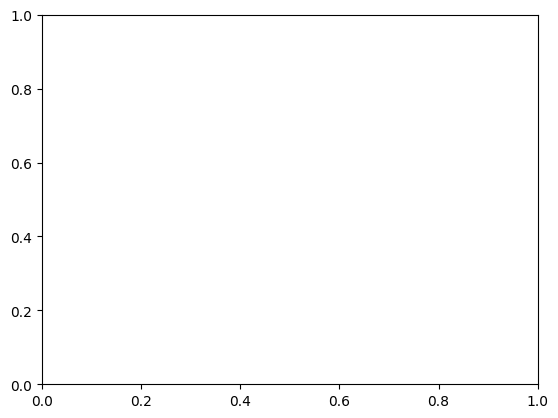

In [ ]:
# Prueba para hacer el histograma
data = df_titanic
listado_completo = {'adult_male': np.float64(0.9999999900051655), 'alone': np.float64(0.9999984140858649), 'pclass': np.float64(0.9999997364060774), 'sibsp': np.float64(0.9999999884318728), 'parch': np.float64(0.9999999999999993), 'embarked': np.float64(0.9971338842842113), 'class': np.float64(0.9999997364060774), 'who': np.float64(1.0), 'embark_town': np.float64(0.9971338842842113)}
columns = listado_completo.keys()
target_col = 'age'
plt.figure()
for column in columns:
    valores = df_titanic[column]
    print(valores)
plt.hist(valores)
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma Agrupado')
plt.legend()
plt.show()

In [45]:
# Voy a clasificar todas las variables categoricas (categoricas y binarias, según sus valores)
listado_binarias = [] # Lista de binarias con valores 0-1, True-False
listado_categoricas = [] # Cajón de sastre donde irán las que no son valores 0-1, True_False, ni numéricas, por tanto string
listado_categorica_numerica = [] # Lista de categoricas con valores numéricos
valores = [0,1] # Condición para las binarias con valores 0-1, True-False
data = df_titanic
lista_binarias = ['survived', 'sex', 'adult_male', 'alive', 'alone']
lista_categoricas = ['pclass', 'sibsp', 'parch', 'embarked', 'class', 'who', 'deck', 'embark_town']
for col in data[lista_binarias].columns: # Para separar las binarias con valores True-False, 0-1
    if data[col].isin(valores).all():
        listado_binarias.append(col)
    else:
        listado_categoricas.append(col) # Resto de categoricas (string)
        
for col in data[lista_categoricas]: # Para separar las numéricas
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        listado_categorica_numerica.append(col)
    else:
        listado_categoricas.append(col) # Resto de categoricas (string)
        
print(listado_categoricas)
print(listado_binarias)
print(listado_categorica_numerica)

['sex', 'alive', 'embarked', 'class', 'who', 'deck', 'embark_town']
['survived', 'adult_male', 'alone']
['pclass', 'sibsp', 'parch']


In [36]:
# ANOVA, contínua + categorica-numerica
import scipy.stats as stats 
listado_completo = {}
data = df_titanic
p_value = 0.05
target_col = 'fare'
for col in data[listado_categorica_numerica].columns:
    resultado_test = stats.f_oneway (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
    if resultado_test[1] < p_value:
        listado_completo[col] = (1-resultado_test[1])
print( listado_completo)

{'pclass': np.float64(1.0), 'sibsp': np.float64(1.0), 'parch': np.float64(1.0)}


In [40]:
# t-test, contínua + categorica binaria (0-1)
import scipy.stats as stats
listado_completo = {}
data = df_titanic
p_value = 0.05
target_col = 'fare'
for col in data[listado_binarias].columns:
    resultado_test = stats.ttest_ind(data[target_col], data[col].dropna(), alternative='two-sided') #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
    if resultado_test[1] < p_value:
        listado_completo[col] = (1-resultado_test[1])
print( listado_completo)

{'survived': np.float64(1.0)}


In [46]:
# Chi2, continua + categorica string
from scipy.stats import chi2_contingency
listado_completo = {}
data = df_titanic
p_value = 0.05
target_col = 'fare'
for col in data[listado_categoricas].columns:
    tabla = pd.crosstab (data[target_col], data[col].dropna()) #uso el dropna para quitar aquellos valores nulos de la columna y que no me de errores 
    resultado_test = chi2_contingency(tabla)
    if resultado_test[1] < p_value:
        listado_completo[col] = (1-resultado_test[1])
print(listado_completo)

{'sex': np.float64(0.9999992631116704), 'alive': np.float64(0.9999999999883523), 'embarked': np.float64(1.0), 'class': np.float64(1.0), 'who': np.float64(1.0), 'deck': np.float64(1.0), 'embark_town': np.float64(1.0)}


In [ ]:
columns = ['survived', 'age', 'fare', 'embarked']
df_seleccionado = df_titanic[columns]
            # Creamos una dataframe para tipificar cada columna y ver qué variables son categóricas, binarias, numéricas contínuas o discretas
df_tipificacion = pd.DataFrame([df_seleccionado.nunique(), df_seleccionado.nunique()/len(df_seleccionado) * 100, df_seleccionado.dtypes]).T.rename(columns = {0: "Card",1: "%_Card", 2: "Tipo"})
        
            # Ahora ya si las clasificamos en función de los resultados de las operaciones realizadas en el apartado anterior
df_tipificacion["Clasificada_como"] = "Categorica" 
df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
df_tipificacion.loc[df_tipificacion["Card"] > 10, "Clasificada_como"] ="Numerica Discreta"
df_tipificacion.loc[df_tipificacion["%_Card"] > 30, "Clasificada_como"] = "Numerica Continua"
print(df_tipificacion) 

         Card     %_Card     Tipo   Clasificada_como
survived    2   0.224467    int64            Binaria
age        88   9.876543  float64  Numerica Discreta
fare      248  27.833895  float64  Numerica Discreta
embarked    3     0.3367   object         Categorica


In [ ]:
data = df_titanic
target_col = 'fare'

if data[target_col].nunique() == 2:
    print ('Binaria')
elif data[target_col].nunique() > 10:
    print('Numerica Discreta')
elif data[target_col].nunique()/len(data) * 100 > 25:
    print('Numerica continua')
else:
    print('Categorica')

Numerica Discreta


In [ ]:
df_titanic = pd.read_csv('/Users/lauragarcia/REPO_PRUEBA/DS_Online_Febr25_Exercises/03_Analisis_de_Datos/Sprint_07/Unidad_01/Practica_Obligatoria/data/titanic.csv')
df_titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
print(get_features_cat_regression(df_titanic, 'fare',p_value=0.05))

            Card     %_Card     Tipo   Clasificada_como
survived       2   0.224467    int64            Binaria
pclass         3     0.3367    int64         Categorica
sex            2   0.224467   object            Binaria
age           88   9.876543  float64  Numerica Discreta
sibsp          7   0.785634    int64         Categorica
parch          7   0.785634    int64         Categorica
fare         248  27.833895  float64  Numerica Discreta
embarked       3     0.3367   object         Categorica
class          3     0.3367   object         Categorica
who            3     0.3367   object         Categorica
adult_male     2   0.224467     bool            Binaria
deck           7   0.785634   object         Categorica
embark_town    3     0.3367   object         Categorica
alive          2   0.224467   object            Binaria
alone          2   0.224467     bool            Binaria
['pclass', 'sibsp', 'parch', 'embarked', 'class', 'who', 'deck', 'embark_town']
['survived', 'sex', 'adu

In [ ]:
df_casas_USA = pd.read_csv('/Users/lauragarcia/Projects/DS_Online_Febr25/04_Machine_Learning/Sprint_10/Unidad_01_Regresion_Lineal_y_Regularizacion/data/USA_Housing.csv')
df_casas_USA

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386
...,...,...,...,...,...,...,...
4995,60567.944140,7.830362,6.137356,3.46,22837.361035,1.060194e+06,USNS Williams\nFPO AP 30153-7653
4996,78491.275435,6.999135,6.576763,4.02,25616.115489,1.482618e+06,"PSC 9258, Box 8489\nAPO AA 42991-3352"
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06,"4215 Tracy Garden Suite 076\nJoshualand, VA 01..."
4998,68001.331235,5.534388,7.130144,5.44,42625.620156,1.198657e+06,USS Wallace\nFPO AE 73316


In [ ]:
print(get_features_cat_regression(df_casas_USA, target_col= 'Price'))

                              Card %_Card     Tipo   Clasificada_como
Avg. Area Income              5000  100.0  float64  Numerica Continua
Avg. Area House Age           5000  100.0  float64  Numerica Continua
Avg. Area Number of Rooms     5000  100.0  float64  Numerica Continua
Avg. Area Number of Bedrooms   255    5.1  float64  Numerica Discreta
Area Population               5000  100.0  float64  Numerica Continua
Price                         5000  100.0  float64  Numerica Continua
Address                       5000  100.0   object  Numerica Continua
[]
[]
['Avg. Area Number of Bedrooms']
['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Area Population', 'Price', 'Address']
[]
[]
[]
[]


In [ ]:
df_ususarios = pd.read_csv('/Users/lauragarcia/Projects/DS_Online_Febr25/04_Machine_Learning/Sprint_10/Unidad_02_Clasificacion_y_Regresion_Logistica/data/usuarios_win_mac_lin.csv')

In [ ]:
print(get_features_cat_regression(df_ususarios, target_col= 'clase'))

Error en la función get_feautures-cat_regression: El argumento introducido como target_col, no es una variable numérica discreta o contínua con alta cardinalidad
None


In [ ]:
df_california = pd.read_csv('/Users/lauragarcia/Projects/DS_Online_Febr25_Exercises/03_Analisis_de_Datos/Sprint_08/Unidad_01/Practica_Obligatoria/data/california_cities.csv')
print(get_features_cat_regression(df_california, target_col= 'latd'))

                   Card     %_Card     Tipo   Clasificada_como
Unnamed: 0          482      100.0    int64  Numerica Continua
city                482      100.0   object  Numerica Continua
latd                474  98.340249  float64  Numerica Continua
longd               473   98.13278  float64  Numerica Continua
elevation_m         241       50.0  float64  Numerica Continua
elevation_ft        271  56.224066  float64  Numerica Continua
population_total    481  99.792531    int64  Numerica Continua
area_total_sq_mi    468  97.095436  float64  Numerica Continua
area_land_sq_mi     479  99.377593  float64  Numerica Continua
area_water_sq_mi    233  48.340249  float64  Numerica Continua
area_total_km2      472  97.925311  float64  Numerica Continua
area_land_km2       476  98.755187  float64  Numerica Continua
area_water_km2      277   57.46888  float64  Numerica Continua
area_water_percent  220  45.643154  float64  Numerica Continua
[]
[]
[]
['Unnamed: 0', 'city', 'latd', 'longd', 'eleva

In [ ]:
df_coches = pd.read_csv('/Users/lauragarcia/Projects/DS_Online_Febr25_Exercises/04_Machine_Learning/Sprint_10/Unidad_01/Ejercicios_Workout/data/CarPrice_Assignment.csv')
print(get_features_cat_regression(df_coches, target_col= 'price'))

                 Card     %_Card     Tipo   Clasificada_como
car_ID            205      100.0    int64  Numerica Continua
symboling           6   2.926829    int64         Categorica
CarName           147  71.707317   object  Numerica Continua
fueltype            2    0.97561   object            Binaria
aspiration          2    0.97561   object            Binaria
doornumber          2    0.97561   object            Binaria
carbody             5   2.439024   object         Categorica
drivewheel          3   1.463415   object         Categorica
enginelocation      2    0.97561   object            Binaria
wheelbase          53  25.853659  float64  Numerica Discreta
carlength          75  36.585366  float64  Numerica Continua
carwidth           44  21.463415  float64  Numerica Discreta
carheight          49  23.902439  float64  Numerica Discreta
curbweight        171  83.414634    int64  Numerica Continua
enginetype          7   3.414634   object         Categorica
cylindernumber      7   